# Metropolis on simple water molecule with straight line intialization

**Anirudh Ghantasala, Datta Group, Purdue University**  
Last updated: 3-30-21  

1. Define the user parameters (timesteps)
2. Define a proposal distribution for particles based on the current state
3. Run simulation 


In [26]:
from openmmtools import mcmc, testsystems, states, cache
from simtk import openmm
from simtk import unit
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import mdtraj as md
import MDAnalysis
import MDAnalysis.analysis.rms


# user parameters ---------------------------------------------------
timesteps = 400
add_noise = True
#--------------------------------------------------------------------

In [27]:
# Proposal Class, implements some logic that proposes a next state based on the current state (initial_positions)
class AddGaussianVector(mcmc.MetropolizedMove):
    def __init__(self, **kwargs):
        super(AddGaussianVector, self).__init__(**kwargs)

    def _propose_positions(self, initial_positions):
        # displacement = unit.Quantity(np.array([1, 1, 1]), initial_positions.unit)
        mean, var = 0, .01
        x_prop, y_prop, z_prop = np.random.normal(mean, var), np.random.normal(mean, var), np.random.normal(mean, var)
        displacement = unit.Quantity(np.array([x_prop, y_prop, z_prop]), initial_positions.unit)
        return initial_positions + displacement


1/3 Initializing...
	success
2/3 Set positions
	success
3/3 Simulating
	Atoms in system:  6
	accepted 603/2400: 


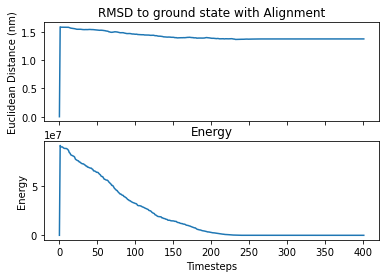

	success


In [28]:
def distance(x, correct):
    for k in range(3):
        x[:, k] -= np.mean(x[:, k])
        correct[:, k] -= np.mean(correct[:, k])
    noise = np.subtract(x, correct)
    return np.sqrt(np.sum(np.square(noise)))

# platform = openmm.Platform.getPlatformByName('CUDA')
# cache.global_context_cache.platform = platform

print('1/3 Initializing...')

# Create the initial state (thermodynamic and microscopic) for the system in vacuum.
water = testsystems.WaterCluster(n_waters=2, constrained=False)

# alanine = testsystems.AlanineDipeptideVacuum(constraints=None)
sampler_state = states.SamplerState(water.positions)
thermodynamic_state = states.ThermodynamicState(water.system, 1 * unit.kelvin)
e, d, rmsd, trajectory = [], [], [], []

context_cache = cache.global_context_cache
context, unused_integrator = context_cache.get_context(thermodynamic_state)
sampler_state.apply_to_context(context)

# initialize energy, distance, and trajectory
correct_state = sampler_state.positions.copy()
e.append(thermodynamic_state.reduced_potential(context))
d.append(distance(sampler_state.positions, sampler_state.positions))
trajectory.append(sampler_state.positions.copy())
rmsd.append(MDAnalysis.analysis.rms.rmsd(correct_state, correct_state, center=True, superposition=True))


print('\tsuccess')

if add_noise:
    print('2/3 Set positions')

    # Add perterbance to correct state
    x = [2, 1, 3, 5, 4, 6]
    y, z = 0,0;
    for i, molecule in enumerate(sampler_state.positions):

        sampler_state.positions[i][0] = unit.quantity.Quantity(value= x[i], unit=unit.nanometer)
        sampler_state.positions[i][1] = unit.quantity.Quantity(value= y, unit=unit.nanometer)
        sampler_state.positions[i][2] = unit.quantity.Quantity(value= z, unit=unit.nanometer)

        
#     print(sampler_state.positions)

    # measure naive euclidean distance
    current_state = sampler_state.positions.copy()
    d.append(distance(current_state, correct_state))
    
    # measure energy
    sampler_state.apply_to_context(context, ignore_velocities=True)
    e.append(thermodynamic_state.reduced_potential(context))

    # build trajectory
    trajectory.append(current_state)

    # measure rmsd with alignment
    rmsd.append(MDAnalysis.analysis.rms.rmsd(current_state, correct_state, center=True, superposition=True))    
    print('\tsuccess')
else:
    print('2/3 skipping noise')
    
    
    

print('3/3 Simulating')
# Create an update MCMC move that brings us back to the initial configuration.
current_state = sampler_state.positions.copy()
total_accepted, total_proposed = 0, 0

print('\tAtoms in system: ', sampler_state.n_particles)

for ii in range(timesteps):
    for jj in range(sampler_state.n_particles):
        move = AddGaussianVector(atom_subset=[jj])
        move.apply(thermodynamic_state, sampler_state)
        if move.n_accepted == 1:
            total_accepted += 1
        total_proposed += 1

    # measure naive euclidean distance
    current_state = sampler_state.positions.copy()
    d.append(distance(current_state, correct_state))
    
    # measure energy
    sampler_state.apply_to_context(context, ignore_velocities=True)
    e.append(thermodynamic_state.reduced_potential(context))

    # build trajectory
    trajectory.append(current_state)

    # measure rmsd with alignment
    rmsd.append(MDAnalysis.analysis.rms.rmsd(current_state, correct_state, center=True, superposition=True))
    
    
    
print('\taccepted {}/{}: '.format(total_accepted, total_proposed))

fig, ((ax1),(ax2)) = plt.subplots(2, 1, sharex=True)
ax1.plot(rmsd, label='Euclidean dist')
ax1.set_title('RMSD to ground state with Alignment')
ax1.set_ylabel('Euclidean Distance (nm)')
ax2.plot(e, label='Energy')
# ax2.set_yscale('log')
ax2.set_title('Energy')
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Energy')
# ax2.text(2, 10, r'Original Energy {}'.format(e[0]), fontsize=15)
plt.show()

print('\tsuccess')

In [29]:
# Visualize the simulation
traj = md.Trajectory(trajectory, topology=water.mdtraj_topology)
traj.save('trajectory.pdb')
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=401)

In [30]:
# get bond angle
import numpy as np

positions = sampler_state.positions.copy()
print(positions.shape)

a = np.array(positions[1,:])
b = np.array(positions[0,:])
c = np.array(positions[2,:])

ba = a - b
bc = c - b

cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
angle = np.arccos(cosine_angle)

print(np.degrees(angle))

(6, 3)
104.78203648428378


In [ ]:
# uncomment to select frame, reflects in above view
# view.frame = 0

# to download movie, open the saved .pdb file in pyMOL and file -> export movie as -> mpeg

## Obsolete cells, may be useful for testing

In [ ]:
# # Generating movie from download images... 
# # code for this cell: https://ambermd.org/tutorials/analysis/tutorial_notebooks/nglview_movie/index.html
# import moviepy.editor as mpy

# from time import sleep


# for frame in range(0, timesteps):
#     # set frame to update coordinates
#     view.frame = frame
#     # make sure to let NGL spending enough time to update coordinates
#     # sleep(0.5)
#     view.download_image(filename='0image{}.png'.format(frame))
#     # make sure to let NGL spending enough time to render before going to next frame
#     sleep(2.0)

# # end download code
# # begin stitching-into-gif code
    
# # In my case, my default download folder is /Users/haichit/Downloads/
# template = '/Users/alasg/Downloads/0image{}.png'

# # get all (sorted) image files
# imagefiles = [template.format(str(i)) for i in range(0, timesteps, 1)]

# frames_per_second = 8
# im = mpy.ImageSequenceClip(imagefiles, fps=frames_per_second)
# im.write_gif('my_movie.gif', fps=frames_per_second)
# # im.write_videofile('my_movie.mp4', fps=frame_per_second)
# from IPython import display

# display.HTML("<img src='my_movie.gif'></img>")

In [ ]:
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(view, download_folder='/Users/alasg/Downloads/', output='my.gif', in_memory=True)
# movie.make()

In [ ]:
# from nglview.contrib.movie import MovieMaker
# moviepy_params = {
#     'codec': 'mpeg4'
# }
# movie = MovieMaker(view, output='my.avi', in_memory=False, moviepy_params=moviepy_params)
# movie.make()

In [ ]:
# JUST TO TEST NGLVIEW INSTALLATION
# import nglview as ngl

# view = nv.show_file(nv.datafiles.ALA3)
# view